### Sequence to Sequence Learning for Language Translation
Sequence to sequence learning involves building a model where data in a domain can be converted to another domain, following the input data sequence. Sequence to sequence learning is especially useful in Natural Language Processing for language translation. In this homework, a sequence to sequence learning model which does language translation(English-French), will be built.


A seq2seq model has two important components which are the encoder and the decoder.

    ~
    RNN layer which serves as the encoder: The encoder receives a sequence as input and returns it’s own internal state. This process continues until the end of the sequence.
    ~
    RNN layer which serves as the decoder: The decoder is trained to predict the next character, given the previous character.(return the target t+1 given the targets t, as defined by the input sequence)
    ~
With the context received from the encoder as input, each state of the decoder returns an output that serves as input for the next state. The output of the decoder is the characters at each time step.
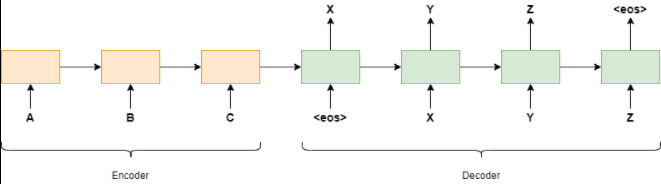

Loading data and defining some variables

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64
epochs = 50 #100
latent_dim = 256 #latent dimensianality of the encoding space
num_samples = 10000

#data
data_path = 'fra.txt'

Generating the textual vectors

In [2]:
# Vectorize the data
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # we use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

Defining the sorted list of English words, the sorted list of Spanish words, the number of English words, the number of Spanish words, the number of characters in the longest English sentence and the number of characters in the longest French sentence

In [3]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [4]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


Defining two dictionary data which hold the index and characters for English and French words

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

The encoder-decoder LSTM model will require 3 important data in numerical array format:

    ~ encoder_input_data: This is a 3-dimensional array, containing the number of pairs in English (input_texts), the maximum length of the English sentence (max_encoder_seq_length), and the number of the English characters (num_encoder_tokens) in the data. 
    ~ decoder_input_data: his is a 3-dimensional array containing the number of pairs in Spanish (input_texts), the maximum length of the Spanish sentences (max_decoder_seq_length), and the number of Spanish characters (num_decoder_tokens).
    ~ decoder_target_data: This data is the same as the input data of the decoder, only that that returns the next character at an offset time t + 1

In [6]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

Changing the textual input texts as numerical vectors

In [7]:
#parse the input and output texts
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep 
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

Defining the encoder input which is the English character sequence as one-hot encodings

In [8]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

Defining the decoder input which is the French character sequence as one-hot encodings

In [9]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Defining the model for the encoder input data, decoder input data and decoder output data

In [10]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  357376      input_2[0][0]                    
                                                                 lstm[0][1]                   

Epoch 46/50
125/125 [==============================] - 21s 168ms/step - loss: 0.1275 - accuracy: 0.9605 - val_loss: 0.5329 - val_accuracy: 0.8748
Epoch 47/50
125/125 [==============================] - 22s 173ms/step - loss: 0.1245 - accuracy: 0.9613 - val_loss: 0.5368 - val_accuracy: 0.8742
Epoch 48/50
125/125 [==============================] - 21s 168ms/step - loss: 0.1214 - accuracy: 0.9623 - val_loss: 0.5400 - val_accuracy: 0.8750
Epoch 49/50
125/125 [==============================] - 21s 169ms/step - loss: 0.1188 - accuracy: 0.9628 - val_loss: 0.5474 - val_accuracy: 0.8742
Epoch 50/50
125/125 [==============================] - 21s 170ms/step - loss: 0.1155 - accuracy: 0.9641 - val_loss: 0.5494 - val_accuracy: 0.8744


Making Predictions - The Inference Model

The training model is not built to recursively return one character at a time,but the Inference Model must do. 

    ~ Encode the input sequence, return its internal states.
    ~ Run the decoder using just the start-of-sequence character as input and the encoder internal states as the decoder's initial states.
    ~ Append the character predicted (after lookup of the token) by the decoder to the decoded sequence
    ~ Repeat the process with the previously predicted character token as input and updates internal states.
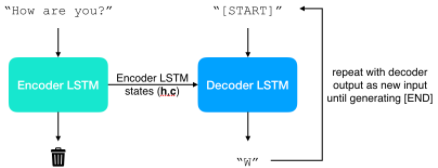

In [11]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


# Reverse-Lookup tokenindex to decode sequences back to something readable
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Defining a function which decodes a text in English to an output French text

In [12]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

Testing a sentence

In [13]:
input_sentence = "How are you?"
test_sentence_tokenized = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')

for t, char in enumerate(input_sentence):
    test_sentence_tokenized[0, t, input_token_index[char]] = 1.
    
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

How are you?
Comment vas-tu ?



Printing some input and decoded sentences

In [14]:
for seq_index in range(30):
    # Take one sentence (part of the training set) for trying out decoding
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Ground Truth sentence:', target_texts[seq_index])

-
Input sentence: Go.
Decoded sentence: Détage !

Ground Truth sentence: 	Va !

-
Input sentence: Go.
Decoded sentence: Détage !

Ground Truth sentence: 	Marche.

-
Input sentence: Go.
Decoded sentence: Détage !

Ground Truth sentence: 	Bouge !

-
Input sentence: Hi.
Decoded sentence: Salut !

Ground Truth sentence: 	Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

Ground Truth sentence: 	Salut.

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentence: 	Cours !

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentence: 	Courez !

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentence: 	Prenez vos jambes à vos cous !

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentence: 	File !

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentence: 	Filez !

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentence: 	Cours !

-
Input sentence: Run!
Decoded sentence: Filez !

Ground Truth sentenc